# Setup

In [1]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.base import BaseEstimator, ClassifierMixin

In [2]:
# Show the graphs here
%pylab inline

# Configuration
pylab.rcParams['figure.figsize'] = (14,8) # figures sizes
import matplotlib.pyplot as plt
plt.style.use('ggplot') # Chose ggplot instead of seaborn

lw = 3 # linewidth in all graphics
sc = 60 # Scatter size
alp=0.6

Populating the interactive namespace from numpy and matplotlib


In [3]:
###############################################################################
# Load data
print("Loading dataset")

from glob import glob
#filenames_neg = sorted(glob(op.join('..', 'data', 'imdb1', 'neg', '*.txt')))
#filenames_pos = sorted(glob(op.join('..', 'data', 'imdb1', 'pos', '*.txt')))

filenames_neg = sorted(glob(op.join('data', 'imdb1', 'neg', '*.txt')))
filenames_pos = sorted(glob(op.join('data', 'imdb1', 'pos', '*.txt')))

texts_neg = [open(f).read() for f in filenames_neg]
texts_pos = [open(f).read() for f in filenames_pos]
texts = texts_neg + texts_pos
y = np.ones(len(texts), dtype=np.int)
y[:len(texts_neg)] = 0.

print("%d documents" % len(texts))

Loading dataset
2000 documents


# IMPLEMENTATION DU CLASSIFIEUR

## Question 1

Compléter la fonction count_words qui va compter le nombre d'occurrences de chaque mot dans une liste de string et renvoyer le vocabulaire

In [4]:
def count_words(texts):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts

    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
        n_samples == number of documents.
        n_features == number of words in vocabulary.
    """
    
    words = set(' '.join(texts).split())
    
    n_features = len(words)
    n_samples = len(texts)
    counts = np.zeros((n_samples, n_features))
    
    # Build vocabulary dictionary - key : word , value : column index in counts array
    vocabulary = { word : i for i, word in enumerate(sorted(words)) }

    # Build counts
    for l, text in enumerate(texts, 0):
        st = text.split()
        for w in st:
            counts[l, vocabulary[w]] +=1

    return vocabulary, counts

### Test sur un jeu de données simple

On teste dans un premier temps sur un petit jeu de données. 

In [5]:
# Test on a small text
text_sample = ["Hello world", "Hello Telecom and world",
               "Hello I love Christmas", "Christmas is coming",
               "Christmas is cool and fun"]
vocabulary_sample, X_sample = count_words(text_sample)

print("--- Vocabulary sample")
print(vocabulary_sample)

import pandas as pd
df_sample = pd.DataFrame(X_sample, columns=sorted(vocabulary_sample))
print()
print("--- X sample")
print(df_sample)

--- Vocabulary sample
{'fun': 7, 'cool': 6, 'Christmas': 0, 'coming': 5, 'love': 9, 'Telecom': 3, 'world': 10, 'is': 8, 'Hello': 1, 'I': 2, 'and': 4}

--- X sample
   Christmas  Hello    I  Telecom  and  coming  cool  fun   is  love  world
0        0.0    1.0  0.0      0.0  0.0     0.0   0.0  0.0  0.0   0.0    1.0
1        0.0    1.0  0.0      1.0  1.0     0.0   0.0  0.0  0.0   0.0    1.0
2        1.0    1.0  1.0      0.0  0.0     0.0   0.0  0.0  0.0   1.0    0.0
3        1.0    0.0  0.0      0.0  0.0     1.0   0.0  0.0  1.0   0.0    0.0
4        1.0    0.0  0.0      0.0  1.0     0.0   1.0  1.0  1.0   0.0    0.0


### Application sur les données réelles

In [6]:
# Count words in texts
vocabulary, X = count_words(texts)

## Question 2

Expliquer comment les classes positives et négatives ont été assignées sur les critiques de film.

D'après le fichier poldata.README.2.0, les analyses peuvent ne pas avoir explicitement de note. Dans le cas où il existe une note, celle-ci peut apparaître à différents sendroits du fichiers et sous différentes formes. Dans le cas de nos données on se focalie uniquement sur les notations les plus explicites, issues d'un set de règles ad-hoc. La classification d'un fichier est donc établie à partir de la première note dont on est capable d'identifier.

- Avec un système de cinq étoiles (ou un systeme numérique équivalent), plus de 3.5 étoiles mènent à une critique positive, et moins de 2 stars mènent à une critique négative.
- Avec un systèmes de quatre étoies (ou un systeme numérique équivalent), plus de 3 stars mènentà une critique positives, et moins de 1.5 stars mènent à une critique négative.
- Avec un systèmes constitué de lettres, B ou au-dessus mène à une critique positive, et C- ou en-dessous est considéré comme négatif.

## Question 3

Compléter la classe NB pour qu'elle implémente le classifieur Naive Bayes.

In [7]:
class NB(BaseEstimator, ClassifierMixin):
    def __init__(self, smoothing=1.0):
        self.smoothing = smoothing

    def fit(self, X, y):
        N = X.shape[0]
        n_words = X.shape[1]
        V = np.arange(n_words)
        
        prior = np.asarray([1 - np.count_nonzero(y) / N,  np.count_nonzero(y) / N])
    
        Tct = np.zeros((n_words, 2))
        
        Tct[:, 0] = np.sum(X[y == 0], axis=0)
        Tct[:, 1] = np.sum(X[y == 1], axis=0)
        
        sum_term = (Tct + self.smoothing)
        cond_prob = sum_term / (np.sum(sum_term, axis=0))
        self.V_ = V
        self.prior_ = prior
        self.cond_prob_ = cond_prob
        
        return self

    def predict(self, X):
        score = np.tile(self.prior_, (X.shape[0], 1))

        for i in range(X.shape[0]):
            score[i, :] += np.sum(np.log(self.cond_prob_[np.flatnonzero(X[i,:]), :]), 
                                  axis=0)
        return np.argmax(score, axis=1)

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

In [8]:
# Test our homemade NB
nb = NB()
nb.fit(X[::2], y[::2])
score = nb.score(X[1::2], y[1::2])
print("Score : ", score)

Score :  0.836


## Question 4

Evaluer les performances de votre classifieur en cross-validation 5-folds

In [9]:
n_folds = 5

In [10]:
from sklearn.model_selection import cross_val_score

In [11]:
scores = cross_val_score(nb, X, y, cv=n_folds)

In [12]:
scores

array([ 0.825 ,  0.825 ,  0.8125,  0.8375,  0.825 ])

## Question 5

Modifier la fonction count_words pour qu'elle ignore les stop words dans le fichier data/english.stop. Les performances sont-elles améliorées ?

In [13]:
filename_stop = 'data/english.stop'
stop_words = set(open(filename_stop).read().split())

In [14]:
def count_words_improved(texts, stop_words=stop_words):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    stop_words : set of str
        The stop words

    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
        n_samples == number of documents.
        n_features == number of words in vocabulary.
    """
    
    words = set(' '.join(texts).split()) - stop_words
    
    n_features = len(words)
    n_samples = len(texts)
    counts = np.zeros((n_samples, n_features))
    
    # Build vocabulary dictionary - key : word , value : column index in counts array
    vocabulary = { word : i for i, word in enumerate(sorted(words)) }
    
    # Build counts
    for l, text in enumerate(texts, 0):
        st = text.split()   
        filtered_words = [word for word in st if word not in stop_words]    
        for w in filtered_words:
            counts[l, vocabulary[w]] +=1
    
    return vocabulary, counts

### Test sur un jeu de données simple

In [15]:
vocabulary_sample_improved, X_sample_improved = count_words_improved(text_sample)

print("--- Vocabulary sample improved")
print(vocabulary_sample_improved)

import pandas as pd
df_sample_improved = pd.DataFrame(X_sample_improved, columns=sorted(vocabulary_sample_improved))
print()
print("--- X sample improved")
print(df_sample_improved)

--- Vocabulary sample improved
{'fun': 6, 'Christmas': 0, 'coming': 4, 'love': 7, 'Telecom': 3, 'world': 8, 'Hello': 1, 'I': 2, 'cool': 5}

--- X sample improved
   Christmas  Hello    I  Telecom  coming  cool  fun  love  world
0        0.0    1.0  0.0      0.0     0.0   0.0  0.0   0.0    1.0
1        0.0    1.0  0.0      1.0     0.0   0.0  0.0   0.0    1.0
2        1.0    1.0  1.0      0.0     0.0   0.0  0.0   1.0    0.0
3        1.0    0.0  0.0      0.0     1.0   0.0  0.0   0.0    0.0
4        1.0    0.0  0.0      0.0     0.0   1.0  1.0   0.0    0.0


Les mots tels que { "is", "and" } sont bien retirés du wordcount. En comparaison, dans notre première version de la fonction, nous avions le résultat suivant :

In [16]:
print("--- X sample")
print(df_sample)

--- X sample
   Christmas  Hello    I  Telecom  and  coming  cool  fun   is  love  world
0        0.0    1.0  0.0      0.0  0.0     0.0   0.0  0.0  0.0   0.0    1.0
1        0.0    1.0  0.0      1.0  1.0     0.0   0.0  0.0  0.0   0.0    1.0
2        1.0    1.0  1.0      0.0  0.0     0.0   0.0  0.0  0.0   1.0    0.0
3        1.0    0.0  0.0      0.0  0.0     1.0   0.0  0.0  1.0   0.0    0.0
4        1.0    0.0  0.0      0.0  1.0     0.0   1.0  1.0  1.0   0.0    0.0


Quant aux autres mots, les valeurs dans la matrice restent bien inchangées.

### Test sur les données réelles

In [17]:
# Count words in text
vocabulary_improved, X_improved = count_words_improved(texts, stop_words)

In [18]:
# Test our homemade NB
nb_stop_words = NB()
nb_stop_words.fit(X_improved[::2], y[::2])
score_stop_words = nb_stop_words.score(X_improved[1::2], y[1::2])
print("Score : ", score_stop_words)

Score :  0.832


In [19]:
# We can also do a cross validation here
scores_stop_words = cross_val_score(nb_stop_words, X_improved, y, cv=n_folds)

In [20]:
scores_stop_words

array([ 0.8175,  0.8275,  0.8325,  0.8525,  0.8125])

In [21]:
print("Score with stop words : ", score)
print("Score without stop words : ", score_stop_words)

print()

print("Cross validation scores with stop words : ", scores)
print("Cross validation scores without stop words : ", scores_stop_words)

Score with stop words :  0.836
Score without stop words :  0.832

Cross validation scores with stop words :  [ 0.825   0.825   0.8125  0.8375  0.825 ]
Cross validation scores without stop words :  [ 0.8175  0.8275  0.8325  0.8525  0.8125]


On obtient donc un meilleur score lorsqu'on prend en compte les stop words dans le word count. La différence n'est cependant pas significative. 
Compte tenu de la faible différence, on peut se demander si les stop words rajoutent du bruit, c'est-à-dire qu'ils ne contribuent pas majoritairement à la détermination d'une classe de documents.

Cependant, on peut remarquer que certains stop words peuvent probablement nuancer une opinion et ainsi avoir un impact sur la classification d'un document. Les connecteurs logiques d'opposition tels que "However" peuvent en effet nuancer une opinion et donner l'aspect négatif du texte, ainsi que les verbes à la forme négative tels que "don't".

# UTILISATION DE SCIKIT-LEARN

In [22]:
n_folds = 5

## Question 1

Comparer votre implémentation avec scikit-learn

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
model_nb = MultinomialNB()

def apply_pipeline(model=model_nb, text=texts, y=y, ngram_range=(1, 1), 
                   analyzer='word', n_folds=5):
    """Create a pipeline for model and a cross validation

    Parameters
    ----------
    model : a sklearn model
        The model
    texts : list of str
        The texts
    ngram_range : tuple
        The ngram range for the CountVectorizer
    analyze : str
        The analyzer for the CountVectorizer
    n_fold : int
        the number of folds for the cross validation
    

    Returns
    -------
    scores : list of floats
        The obtained score after cross validation
    elapsed : list of float
        The time elapsed during execution
    """
    start = time.time()
    pipeline = Pipeline([
    ('counts', CountVectorizer(ngram_range=ngram_range, analyzer=analyzer)),
    ('classifier', model)
    ])

    scores = cross_val_score(pipeline, text, y, cv=n_folds)
    end = time.time()
    
    elapsed = end - start
    return scores, elapsed

In [25]:
def test_model(model=model_nb, text=texts, y=y, n_folds=5):
    """Apply pipeline and cross validation for analyzers words, bigrams, and chars
    Parameters
    ----------
    model : a sklearn model
        The model
    texts : list of str
        The texts
    n_fold : int
        the number of folds for the cross validation
        
    Returns
    -------
    scores : lists of floats
        The obtained scores for the three tests
    elapsed : list of float
        The time elapsed during execution
    """
    
    # Words
    print("--- Words")
    scores_w, elapsed_w = apply_pipeline(model=model, text=text, y=y, 
                                         n_folds=n_folds)
    print("    | Scores: ", scores_w)
    print("    | Accuracy: %0.2f (+/- %0.2f)" % (scores_w.mean(), scores_w.std() * 2))
    print("    | Time elapsed (s): ", elapsed_w)

    # Bigrams
    print("--- Bigrams")
    scores_b, elapsed_b = apply_pipeline(model=model, text=text, y=y, 
                                         ngram_range=(1, 2), analyzer='word', 
                                         n_folds=n_folds)
    print("    | Scores: ", scores_b)
    print("    | Accuracy: %0.2f (+/- %0.2f)" % (scores_b.mean(), scores_b.std() * 2))
    print("    | Time elapsed (s): ", elapsed_b)

    # Char
    print("--- Chars")
    scores_c, elapsed_c = apply_pipeline(model=model, text=text, y=y, 
                                         ngram_range=(3, 6), analyzer='char', 
                                         n_folds=n_folds)
    print("    | Scores: ", scores_c)
    print("    | Accuracy: %0.2f (+/- %0.2f)" % (scores_c.mean(), scores_c.std() * 2))
    print("    | Time elapsed (s): ", elapsed_c)    
    
    return [scores_w, scores_b, scores_c], [elapsed_w, elapsed_b, elapsed_c]

In [26]:
[scores_w, scores_b, scores_c], [elapsed_w, elapsed_b, elapsed_c] = test_model()

--- Words
    | Scores:  [ 0.81   0.825  0.81   0.825  0.79 ]
    | Accuracy: 0.81 (+/- 0.03)
    | Time elapsed (s):  7.997492074966431
--- Bigrams
    | Scores:  [ 0.8175  0.8375  0.8225  0.8425  0.8325]
    | Accuracy: 0.83 (+/- 0.02)
    | Time elapsed (s):  33.28206276893616
--- Chars
    | Scores:  [ 0.8225  0.825   0.8175  0.845   0.7975]
    | Accuracy: 0.82 (+/- 0.03)
    | Time elapsed (s):  391.97445607185364


In [27]:
scores_nb = [scores_w, scores_b, scores_c]

### Résultats obtenus avec Scikit Learn

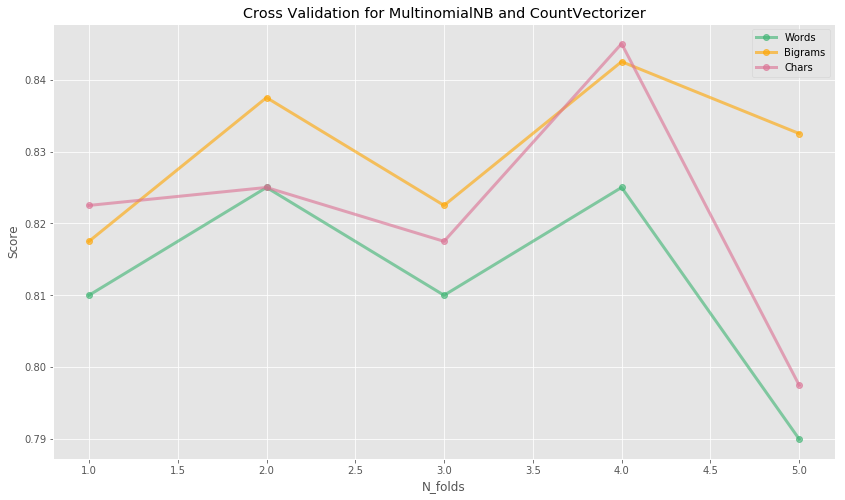

In [28]:
# Plot all
plt.plot(np.arange(n_folds) + 1, scores_w, linewidth=lw, alpha=alp, 
         marker='o', color="mediumseagreen", label='Words')

plt.plot(np.arange(n_folds) + 1, scores_b, linewidth=lw, alpha=alp, 
         marker='o', color="orange", label='Bigrams')

plt.plot(np.arange(n_folds) + 1, scores_c, linewidth=lw, alpha=alp, 
         marker='o', color="palevioletred", label='Chars')

plt.xlabel("N_folds")
plt.ylabel("Score")
plt.title("Cross Validation for MultinomialNB and CountVectorizer")
plt.legend()
plt.show()

plt.close()

### Comparaison avec notre implémentation

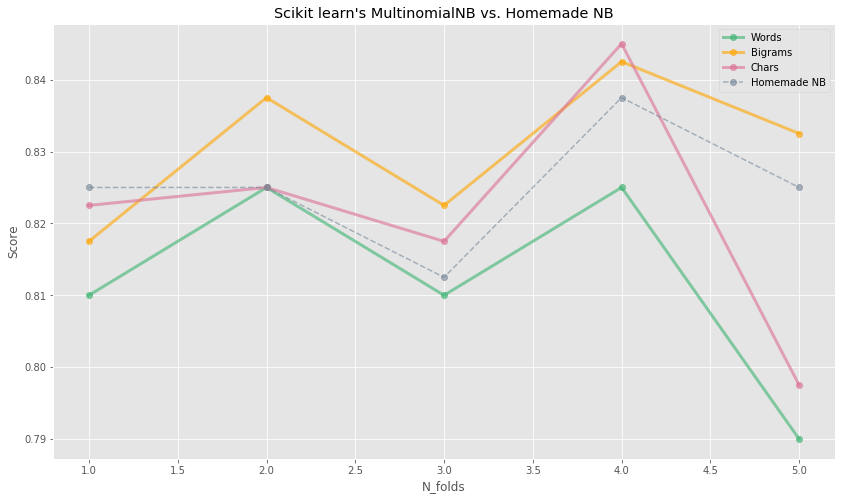

In [29]:
# Compare with homemade NB
plt.plot(np.arange(n_folds) + 1, scores_w, linewidth=lw, alpha=alp, 
         marker='o', color="mediumseagreen", label='Words')

plt.plot(np.arange(n_folds) + 1, scores_b, linewidth=lw, alpha=alp, 
         marker='o', color="orange", label='Bigrams')

plt.plot(np.arange(n_folds) + 1, scores_c, linewidth=lw, alpha=alp, 
         marker='o', color="palevioletred", label='Chars')

plt.plot(np.arange(n_folds) + 1, scores, '--', linewidth=lw/2, alpha=alp, 
         marker='o', color="lightslategrey", label='Homemade NB')

plt.xlabel("N_folds")
plt.ylabel("Score")
plt.title("Scikit learn's MultinomialNB vs. Homemade NB")
plt.legend()
plt.show()

plt.close()

Le graphique ci-dessus présente les courbes obtenues avec l'implémentationde Naive Bayes de Scikit Learn, ainsi que la courbe obtenue dans la partie précédente avec notre propre implémentation du modèle. 
- D'une part les résultats obtenus avec Scikit learn semblent globalement meilleurs qu'avec notre implémentation (avec Bigrams et Chars)
- D'autre part on remarque des différences entre les différents types d'analyzer. Les valeurs de scores sont plus élevées avec Bigrams et Chars qu'avec Words

Les scores obtenus avec les bigrammes sont visiblement meilleurs que pour les chars et les mots. L'idée de prendre en compte les bigrammes et d'obtenir la probabilité qu'un mot A apparaisse dans notre extrait, suivi du mot B.
La fréquence de distribution d'un bigramme dans une chaine permet de déterminer la probabilité d'un token, connaissant le token précédent.

En prenant en compte les chaînes de caractères, les scores sont moins bons que pour les mots et les bigrammes. Contrairement aux bigrammes où la prise en compte de l'enchaînement des mots améliore de score, la prise en compte de sous-chaines de caractères seules et non de probabilités de succession d'une autre chaîne dégrade les résultats.

Les graphiques ci-dessus permettent de visualiser les courbes de score, ainsi que les valeurs d'écart-type associées. On remarque que l'écart-type de la dernière courbe - correspondont à l'analyzer char - est plus bas que dans les deux autres cas.

## Question 2

In [30]:
# Define a plot function for the following questions
def plot_comparison(scores1, scores2, model_name1, model_name2):
    plt.plot(np.arange(n_folds) + 1, scores1[0], linewidth=lw, alpha=alp, 
             marker='o', color="mediumseagreen", label='Words' + model_name1)
    plt.plot(np.arange(n_folds) + 1, scores2[0], '--', linewidth=lw/2, alpha=alp, 
             marker='o', color="mediumseagreen", label='Words' + model_name2)

    plt.plot(np.arange(n_folds) + 1, scores1[1], linewidth=lw, alpha=alp, 
             marker='o', color="orange", label='Bigrams' + model_name1)
    plt.plot(np.arange(n_folds) + 1, scores2[1], '--', linewidth=lw/2, alpha=alp, 
             marker='o', color="orange", label='Bigrams' + model_name2)

    plt.plot(np.arange(n_folds) + 1, scores1[2], linewidth=lw, alpha=alp, 
             marker='o', color="palevioletred", label='Chars' + model_name1)
    plt.plot(np.arange(n_folds) + 1, scores2[2], '--', linewidth=lw/2, alpha=alp, 
             marker='o', color="palevioletred", label='Chars' + model_name2)

    plt.xlabel("N_folds")
    plt.ylabel("Score")
    
    title = "Comparison " + model_name1 + " vs. " + model_name2 
    plt.title(title)
    plt.legend()
    plt.show()

    plt.close()

### Logistic regression

In [31]:
from sklearn.linear_model import LogisticRegression

# Test with Logistic Regression
model_lr = LogisticRegression()

[scores_w_lr, scores_b_lr, scores_c_lr], [elapsed_w_lr, elapsed_b_lr, elapsed_c_lr] = test_model(model=model_lr)

--- Words
    | Scores:  [ 0.815   0.8425  0.8375  0.8675  0.845 ]
    | Accuracy: 0.84 (+/- 0.03)
    | Time elapsed (s):  27.586987018585205
--- Bigrams
    | Scores:  [ 0.8225  0.855   0.85    0.87    0.865 ]
    | Accuracy: 0.85 (+/- 0.03)
    | Time elapsed (s):  116.26668787002563
--- Chars
    | Scores:  [ 0.8275  0.835   0.8425  0.845   0.855 ]
    | Accuracy: 0.84 (+/- 0.02)
    | Time elapsed (s):  613.3107368946075


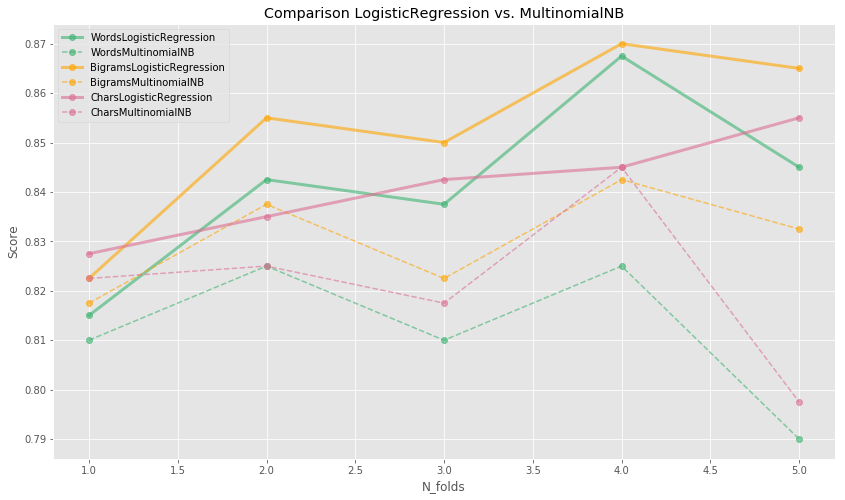

In [32]:
# Compare LogisticRegression with MultinomialNB
scores_lr = [scores_w_lr, scores_b_lr, scores_c_lr]

plot_comparison(scores_lr, scores_nb, "LogisticRegression", "MultinomialNB")

Avec LogisticRegression on obtient de meilleurs résultats dans les trois cas (Words, Bigrams, Chars) qu'avec MultinomialNB.

### Linear SVC

In [33]:
from sklearn.svm import LinearSVC

# Test with LinearSVC
model_svc = LinearSVC()

[scores_w_svc, scores_b_svc, scores_c_svc], [elapsed_w_svc, elapsed_b_svc, elapsed_c_svc] = test_model(model=model_svc)

--- Words
    | Scores:  [ 0.8025  0.84    0.83    0.85    0.84  ]
    | Accuracy: 0.83 (+/- 0.03)
    | Time elapsed (s):  15.670583009719849
--- Bigrams
    | Scores:  [ 0.8175  0.845   0.8475  0.87    0.87  ]
    | Accuracy: 0.85 (+/- 0.04)
    | Time elapsed (s):  147.2756040096283
--- Chars
    | Scores:  [ 0.81   0.835  0.84   0.845  0.83 ]
    | Accuracy: 0.83 (+/- 0.02)
    | Time elapsed (s):  569.5203940868378


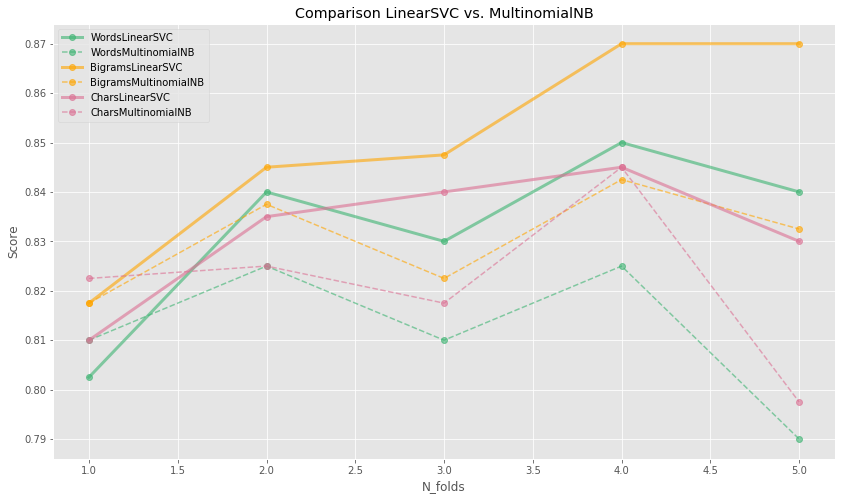

In [34]:
# Compare LinearSVC with MultinomialNB
scores_svc = [scores_w_svc, scores_b_svc, scores_c_svc]

plot_comparison(scores_svc, scores_nb, "LinearSVC", "MultinomialNB")

Avec LinearSVC on obtient de meilleurs résultats dans les trois cas (Words, Bigrams, Chars) qu'avec MultinomialNB.

### Logistic Regression / LinearSVC

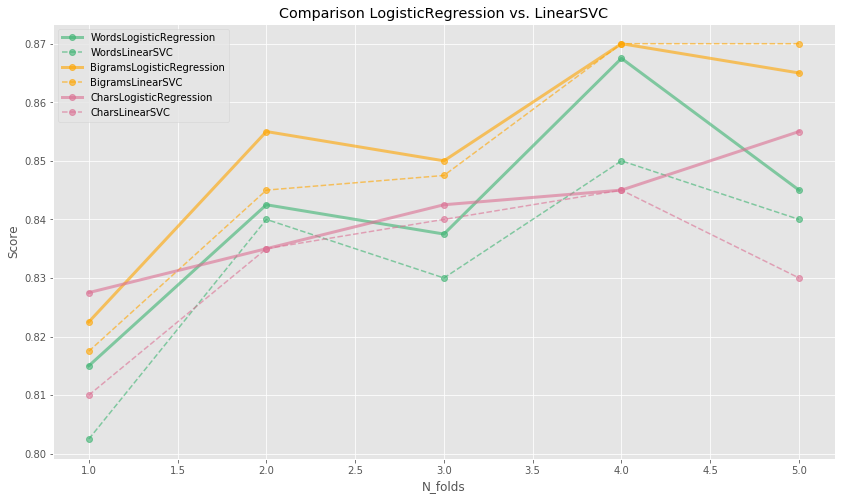

In [35]:
# Finally : Compare LogisticRegression with LinearSVC
plot_comparison(scores_lr, scores_svc, "LogisticRegression", "LinearSVC")

On a démontré au-dessus que les modèles LogisticRegression et LinearSVC mènent tous les deux à de meilleurs scores de prédiction que MultinomialNB. Les deux modèles permetttent en effet de tenir compte des dépendances entre les attributs, et donc en particulier dans une analyse sémantique, d'où les meilleurs résultats.
En comparant désormais les deux modèles, on remarque que LogisticRegression obtient dans l'ensemble de meilleurs scores que LinearSVC dans le cadre de nos données.

Dans la suite du TP nous poursuivrons avec MultinomialNB et LinearSVC (par choix).

## Question 3

Utiliser la libraire NLTK afin de procéder à une racinisation (stemming). Vous utiliserez la classe SnowballStemmer

In [36]:
from nltk import SnowballStemmer

In [37]:
stemmer_test = SnowballStemmer("english")
print(stemmer_test.stem("running")) # small test

run


In [38]:
def stem(texts=texts):
    stemmed = []
    stemmer = SnowballStemmer("english")
    for i, text in enumerate(texts, 0):
        stemmed.append('')
        words = text.split(' ')
        for word in words:
            stemmed[i] += stemmer.stem(word) + ' '    
    return stemmed

### Test sur un texte simple

In [39]:
simple = ["I eat he eats", "She loves eating"]

simple_stemmed = stem(texts=simple)
print(simple_stemmed)

['i eat he eat ', 'she love eat ']


### Test sur les données réelles

In [40]:
stemmed = stem()

### MultinomialNB

In [41]:
[scores_w_stm, scores_b_stm, scores_c_stm], [elapsed_w_stm, elapsed_b_stm, elapsed_c_stm] = test_model(text=stemmed)

--- Words
    | Scores:  [ 0.795   0.815   0.8     0.83    0.8025]
    | Accuracy: 0.81 (+/- 0.03)
    | Time elapsed (s):  8.297225952148438
--- Bigrams
    | Scores:  [ 0.8275  0.84    0.815   0.8425  0.8175]
    | Accuracy: 0.83 (+/- 0.02)
    | Time elapsed (s):  45.853594064712524
--- Chars
    | Scores:  [ 0.815   0.8125  0.8125  0.8525  0.8125]
    | Accuracy: 0.82 (+/- 0.03)
    | Time elapsed (s):  333.6116421222687


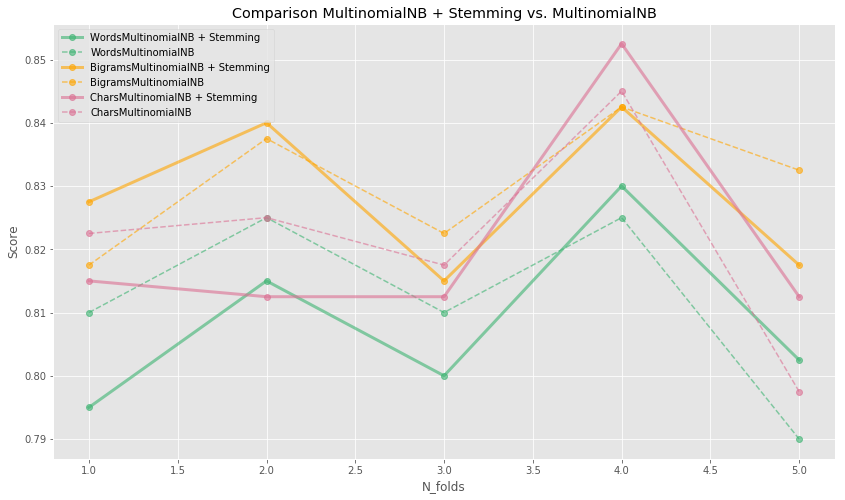

In [42]:
# Compare new scores with stemming with original MultinomialNB
scores_stm = [scores_w_stm, scores_b_stm, scores_c_stm]

plot_comparison(scores_stm, scores_nb, "MultinomialNB + Stemming", "MultinomialNB")

Les scores obtenus après une cross validation avec la racinisation sont globalement plus faibles qu'auparavant. 

La racinisation coupe les mots écrits sous leur forme exacte et produit des bases de mots pour la classification. Cependant, les détails associés à a forme exacte du mots peuvent jouer un rôle primordial dans le texte. La racinisation dégrade alors la classification.

### LinearSVC

In [43]:
[scores_w_svc_stm, scores_b_svc_stm, scores_c_svc_stm], [elapsed_w_svc_stm, elapsed_b_svc_stm, elapsed_c_svc_stm] = test_model(model=model_svc, text=stemmed)

--- Words
    | Scores:  [ 0.815   0.85    0.825   0.8225  0.86  ]
    | Accuracy: 0.83 (+/- 0.03)
    | Time elapsed (s):  13.600510120391846
--- Bigrams
    | Scores:  [ 0.8375  0.8625  0.8475  0.855   0.88  ]
    | Accuracy: 0.86 (+/- 0.03)
    | Time elapsed (s):  50.19047284126282
--- Chars
    | Scores:  [ 0.8275  0.8225  0.84    0.83    0.8275]
    | Accuracy: 0.83 (+/- 0.01)
    | Time elapsed (s):  564.7897400856018


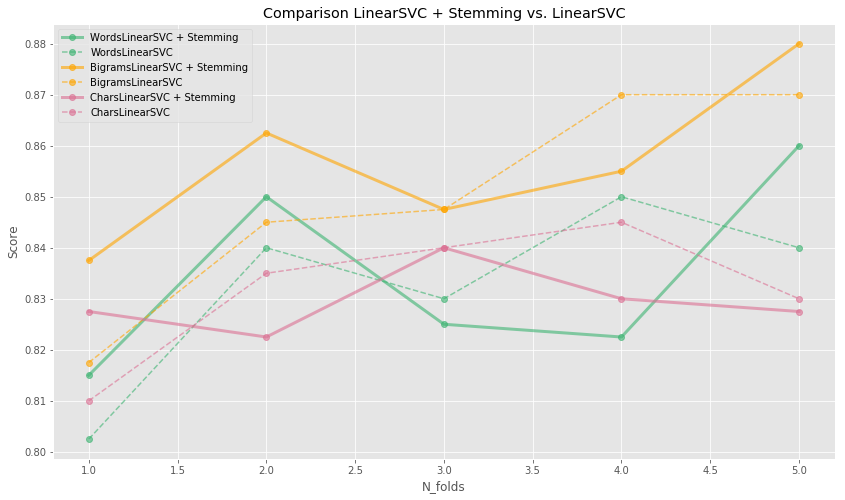

In [44]:
# Compare new scores with stemming with original MultinomialNB
scores_svc_stm = [scores_w_svc_stm, scores_b_svc_stm, scores_c_svc_stm]

plot_comparison(scores_svc_stm, scores_svc, "LinearSVC + Stemming", "LinearSVC")

Dans le cas de LinearSVC, la racinisation amène à des scores relativement satisfaisants par rapport au modèle LinearSVC de bas. Cela peut s'expliquer par le fait que le modèle prend en compte les dépendances entre les attributs, ce qui mène à des résultats améliorés dans le cas d'une analyse sémantique.

## Question 4

Filtrer les mots par catégorie grammaticale (POS : Part Of Speech) et ne garder que les noms, les verbes, les adverbes et les adjectifs pour la classification

In [45]:
from nltk import Text
from nltk import pos_tag
from nltk import word_tokenize

#import nltk
#nltk.download()

In [46]:
# Define a filtering function
def filter_pos(texts=texts):
    filtered = [list(filter(lambda x: (x[1] == 'NOUN') 
                         or (x[1] == 'VERB') 
                         or (x[1] == 'ADV') 
                         or (x[1] == 'ADJ'), pos_tag(word_tokenize(txt), tagset='universal'))) for txt in texts]
    return filtered

def apply_pos_tag(filtered):
    postagged = []
    for i, tuples in enumerate(filtered, 0):
        postagged.append('')
        for t in tuples:
            postagged[i] += t[0] + ' '
    return postagged

### Test sur un texte simple

In [47]:
simple_new = ["Today is a beautiful day", "Christmas is coming", "Tonight is freezing and cold"]

pos_simple = filter_pos(texts=simple_new)
print(pos_simple)

[[('Today', 'NOUN'), ('is', 'VERB'), ('beautiful', 'ADJ'), ('day', 'NOUN')], [('Christmas', 'NOUN'), ('is', 'VERB'), ('coming', 'VERB')], [('Tonight', 'NOUN'), ('is', 'VERB'), ('freezing', 'VERB'), ('cold', 'ADJ')]]


In [48]:
postagged_simple = apply_pos_tag(pos_simple)
print(postagged_simple)

['Today is beautiful day ', 'Christmas is coming ', 'Tonight is freezing cold ']


### Test sur les données réelles

In [49]:
filtered = filter_pos()

In [50]:
postagged = apply_pos_tag(filtered)

### MultinomialNB

In [51]:
[scores_w_pst, scores_b_pst, scores_c_pst], [elapsed_w_pst, elapsed_b_pst, elapsed_c_pst] = test_model(text=postagged)

--- Words
    | Scores:  [ 0.8025  0.8175  0.805   0.835   0.795 ]
    | Accuracy: 0.81 (+/- 0.03)
    | Time elapsed (s):  5.83814001083374
--- Bigrams
    | Scores:  [ 0.8075  0.835   0.83    0.8625  0.8275]
    | Accuracy: 0.83 (+/- 0.04)
    | Time elapsed (s):  25.249979972839355
--- Chars
    | Scores:  [ 0.805   0.8175  0.8     0.85    0.8   ]
    | Accuracy: 0.81 (+/- 0.04)
    | Time elapsed (s):  206.31769680976868


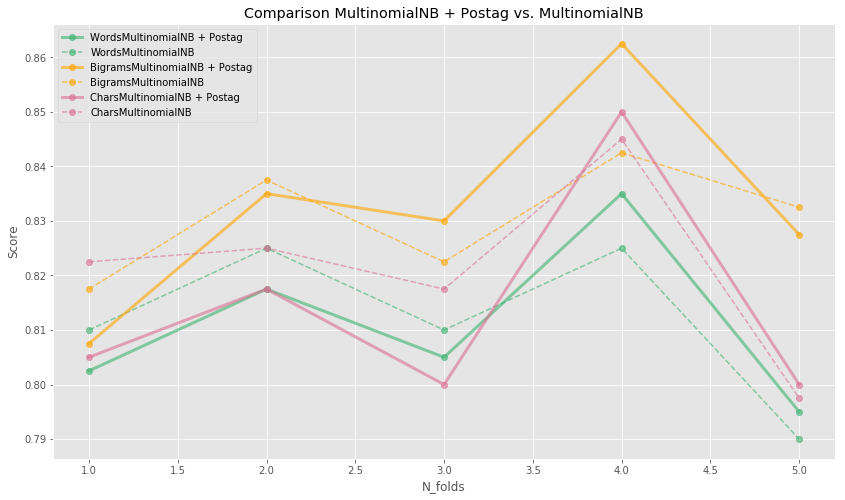

In [52]:
# Compare new scores with postagged with original MultinomialNB
scores_pst = [scores_w_pst, scores_b_pst, scores_c_pst]

plot_comparison(scores_pst, scores_nb, "MultinomialNB + Postag", "MultinomialNB")

### LinearSVC

In [53]:
[scores_w_svc_pst, scores_b_svc_pst, scores_c_svc_pst], [elapsed_w_svc_pst, elapsed_b_svc_pst, elapsed_c_svc_pst] = test_model(model=model_svc, text=postagged)

--- Words
    | Scores:  [ 0.81   0.84   0.82   0.845  0.84 ]
    | Accuracy: 0.83 (+/- 0.03)
    | Time elapsed (s):  9.077815055847168
--- Bigrams
    | Scores:  [ 0.8225  0.8575  0.8325  0.8575  0.855 ]
    | Accuracy: 0.84 (+/- 0.03)
    | Time elapsed (s):  51.60603308677673
--- Chars
    | Scores:  [ 0.81    0.82    0.815   0.8325  0.835 ]
    | Accuracy: 0.82 (+/- 0.02)
    | Time elapsed (s):  329.51761507987976


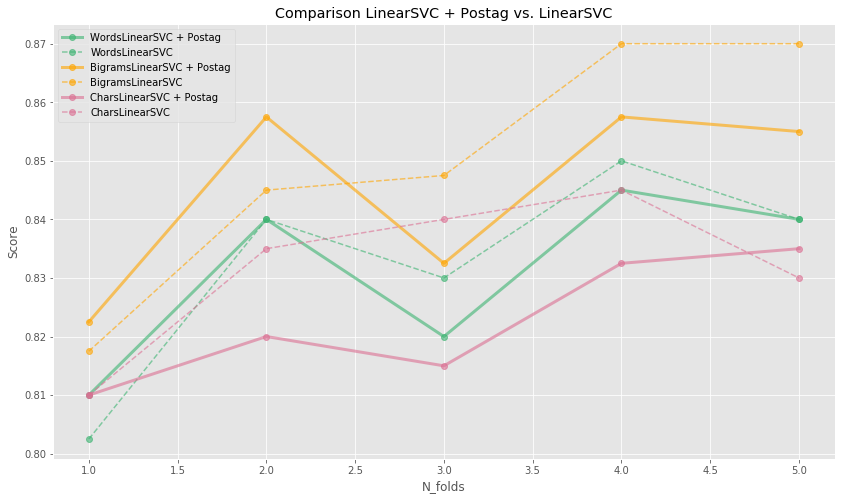

In [54]:
# Compare new scores with postagged with original MultinomialNB
scores_svc_pst = [scores_w_svc_pst, scores_b_svc_pst, scores_c_svc_pst]

plot_comparison(scores_svc_pst, scores_svc, "LinearSVC + Postag", "LinearSVC")

De manière générale, les résultats obtenus avec pos_tag sont moins bons que les résultats obtenus avec le modèle d'origine, pour le modèle MultinomialNB comme pour LinearSVC. Le filtrage des mots par catégorie grammaticale ne semble pas améliorer les resultats de classification.

## Récapitulatif

### --- Scores

In [55]:
models_originals = [scores_w, scores_b, scores_c]
models_stemming = [scores_w_stm,  scores_b_stm, scores_c_stm]
models_postag = [scores_w_pst, scores_b_pst, scores_c_stm]

In [56]:
models_svc = [scores_w_svc, scores_b_svc, scores_c_svc]
models_svc_stemming = [scores_w_svc_stm, scores_b_svc_stm, scores_c_svc_stm]
models_svc_postag = [scores_w_svc_pst, scores_b_svc_pst, scores_c_svc_stm]

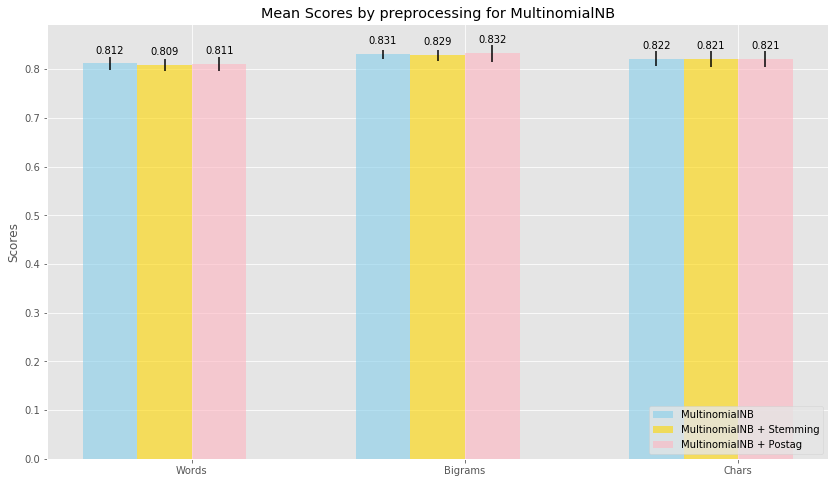

In [57]:
fig, ax = plt.subplots()

ind = np.arange(len(models_originals))
width = 0.2

rects1 = ax.bar(ind, [mean(l) for l in models_originals], 
                width, alpha=alp, label='MultinomialNB', color='skyblue', 
                yerr=[np.std(l) for l in models_originals])

rects2 = ax.bar(ind + width, [mean(l) for l in models_stemming], 
                width, alpha=alp, label='MultinomialNB + Stemming', color='gold', 
                yerr=[np.std(l) for l in models_stemming])

rects3 = ax.bar(ind + 2 * width, [mean(l) for l in models_postag], 
                width, alpha=alp, label='MultinomialNB + Postag', color='lightpink', 
                yerr=[np.std(l) for l in models_postag])

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Mean Scores by preprocessing for MultinomialNB')
ax.set_xticks(ind + 3 * width / 2)
ax.set_xticklabels(('Words', 'Bigrams', 'Chars'))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '%.3f' % height,
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.legend(loc="lower right")
plt.show()

Bien que l'on obtient des valeurs de score différentes selon les modèles utilisés durant cette partie, les valeurs ont des ordres de grandeur tout à fait similaires. Des traitements des données avant l'utilisation du modèle, comme la racinisation, semblent toutefois diminuer le score final. 
En comparaison avec le Naive Bayes, LinearSVC amène à de meilleurs scores sur nos données. 

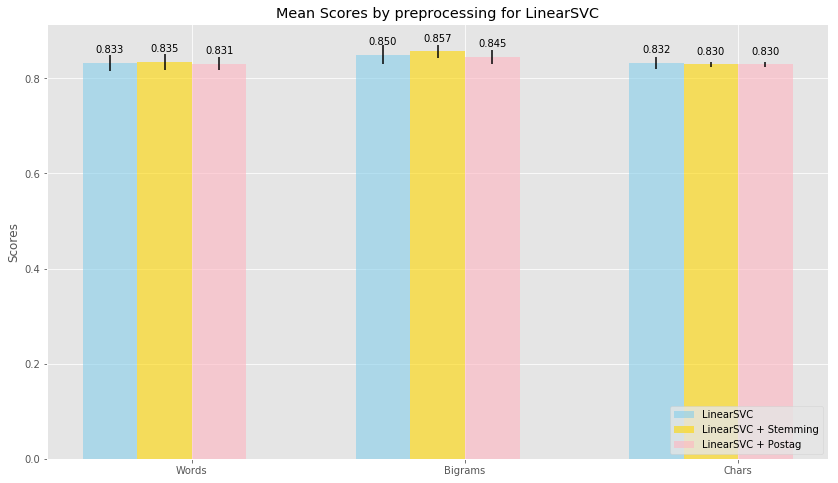

In [58]:
fig, ax = plt.subplots()

ind = np.arange(len(models_originals))
width = 0.2

rects1_svc = ax.bar(ind, [mean(l) for l in models_svc], 
                width, alpha=alp, label='LinearSVC', color='skyblue', 
                yerr=[np.std(l) for l in models_svc])

rects2_svc = ax.bar(ind + width, [mean(l) for l in models_svc_stemming], 
                width, alpha=alp, label='LinearSVC + Stemming', color='gold', 
                yerr=[np.std(l) for l in models_svc_stemming])

rects3_svc = ax.bar(ind + 2 * width, [mean(l) for l in models_svc_postag], 
                width, alpha=alp, label='LinearSVC + Postag', color='lightpink', 
                yerr=[np.std(l) for l in models_svc_postag])

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Mean Scores by preprocessing for LinearSVC')
ax.set_xticks(ind + 3 * width / 2)
ax.set_xticklabels(('Words', 'Bigrams', 'Chars'))

autolabel(rects1_svc)
autolabel(rects2_svc)
autolabel(rects3_svc)

plt.legend(loc="lower right")
plt.show()

### --- Temps d'exécution

In [59]:
elapsed_originals = [elapsed_w, elapsed_b, elapsed_c]
elapsed_stemming = [elapsed_w_stm, elapsed_b_stm, elapsed_c_stm]
elapsed_postag = [elapsed_w_pst, elapsed_b_pst, elapsed_c_stm]

In [60]:
elapsed_svc = [elapsed_w_svc, elapsed_b_svc, elapsed_c_svc]
elapsed_svc_stemming = [elapsed_w_svc_stm, elapsed_b_svc_stm, elapsed_c_svc_stm]
elapsed_svc_postag = [elapsed_w_svc_pst, elapsed_b_svc_pst, elapsed_c_svc_pst]

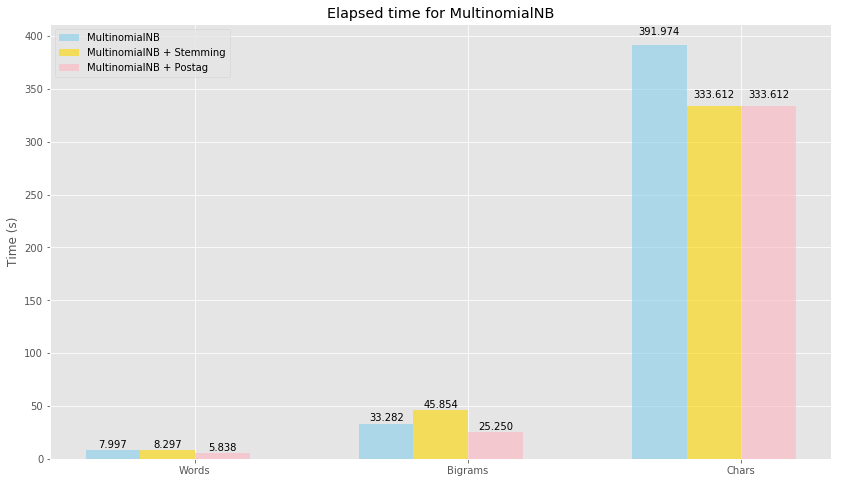

In [61]:
fig, ax = plt.subplots()

ind = np.arange(len(models_originals))
width = 0.2

rects1_elps = ax.bar(ind, elapsed_originals, 
                width, alpha=alp, label='MultinomialNB', color='skyblue')

rects2_elps = ax.bar(ind + width, elapsed_stemming, 
                width, alpha=alp, label='MultinomialNB + Stemming', color='gold')

rects3_elps = ax.bar(ind + 2 * width, elapsed_postag, 
                width, alpha=alp, label='MultinomialNB + Postag', color='lightpink')

# add some text for labels, title and axes ticks
ax.set_ylabel('Time (s)')
ax.set_title('Elapsed time for MultinomialNB')
ax.set_xticks(ind + 3 * width / 2)
ax.set_xticklabels(('Words', 'Bigrams', 'Chars'))

autolabel(rects1_elps)
autolabel(rects2_elps)
autolabel(rects3_elps)

plt.legend()
plt.show()

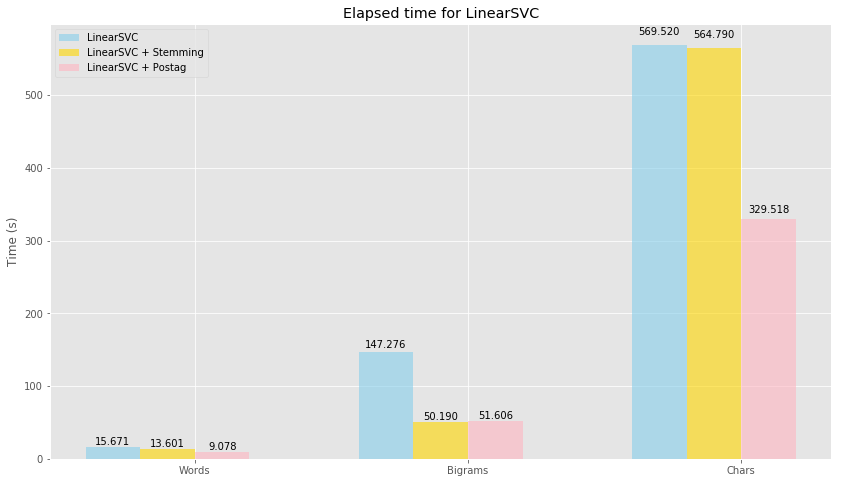

In [62]:
fig, ax = plt.subplots()

ind = np.arange(len(models_originals))
width = 0.2

rects1_elps = ax.bar(ind, elapsed_svc, 
                width, alpha=alp, label='LinearSVC', color='skyblue')

rects2_elps = ax.bar(ind + width, elapsed_svc_stemming, 
                width, alpha=alp, label='LinearSVC + Stemming', color='gold')

rects3_elps = ax.bar(ind + 2 * width, elapsed_svc_postag, 
                width, alpha=alp, label='LinearSVC + Postag', color='lightpink')

# add some text for labels, title and axes ticks
ax.set_ylabel('Time (s)')
ax.set_title('Elapsed time for LinearSVC')
ax.set_xticks(ind + 3 * width / 2)
ax.set_xticklabels(('Words', 'Bigrams', 'Chars'))

autolabel(rects1_elps)
autolabel(rects2_elps)
autolabel(rects3_elps)

plt.legend()
plt.show()

Le temps d'exécution des modèles pour les caractères est largement plus élevé que pour les mots et les bigrammes. Cela est dû au grand nombre de données supplémentaires à prendre en compte en considérant les sous-chaînes de caractères.